# Actividad 1 - Guia 2

#### Proyecto 2 - Modelos de clasificación supervisada para evaluar la calidad de un automovil

Integrantes: 
* Victor Andres Vargas Niño
* Melissa Garcia Herrera

#### Descripción del problema

Evaluaremos la información del conjunto de registros car.data, la idea es construir un modelo que evalúe los coches según las siguientes variables:

* buying: es el precio de compra del carro (variable Categorica)
* maint: es el precio de mantenimiento del carro (variable Categorica)
* doors: la cantidad de puertas que tiene el carro (variable Categorica)
* persons: capacidad en términos de personas para transportar (variable Categorica)
* lug_boot: tamaño del maletero (variable Categorica)
* safety: seguridad estimada del carro (variable Categorica)
* class: evaluación del nivel del carro ya sea aceptable, no aceptable, bueno, muy bueno (variable Categorica)

#### Librerias

In [132]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier


#### 4. Carga de los datos

In [133]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

#### Determine la cantidad de variables y registros, indique cuales son numéricas y cualitativas y haga un resumen de esa información

In [134]:
car_evaluation.variables[['name','role','type','description','missing_values']]

,name,role,type,description,missing_values
0,buying,Feature,Categorical,buying price,no
1,maint,Feature,Categorical,price of the maintenance,no
2,doors,Feature,Categorical,number of doors,no
3,persons,Feature,Categorical,capacity in terms of persons to carry,no
4,lug_boot,Feature,Categorical,the size of luggage boot,no
5,safety,Feature,Categorical,estimated safety of the car,no
6,class,Target,Categorical,"evaulation level (unacceptable, acceptable, go...",no


In [135]:
df = pd.DataFrame(car_evaluation.data.features, columns=car_evaluation.variables.name)
df['class'] = car_evaluation.data.targets 
df.head()

name,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [136]:
def show(df):
  for i in df.columns[0:]:
    print("Variable: {} {}".format(i,df[i].unique()))

show(df)

Variable: buying ['vhigh' 'high' 'med' 'low']
Variable: maint ['vhigh' 'high' 'med' 'low']
Variable: doors ['2' '3' '4' '5more']
Variable: persons ['2' '4' 'more']
Variable: lug_boot ['small' 'med' 'big']
Variable: safety ['low' 'med' 'high']
Variable: class ['unacc' 'acc' 'vgood' 'good']


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


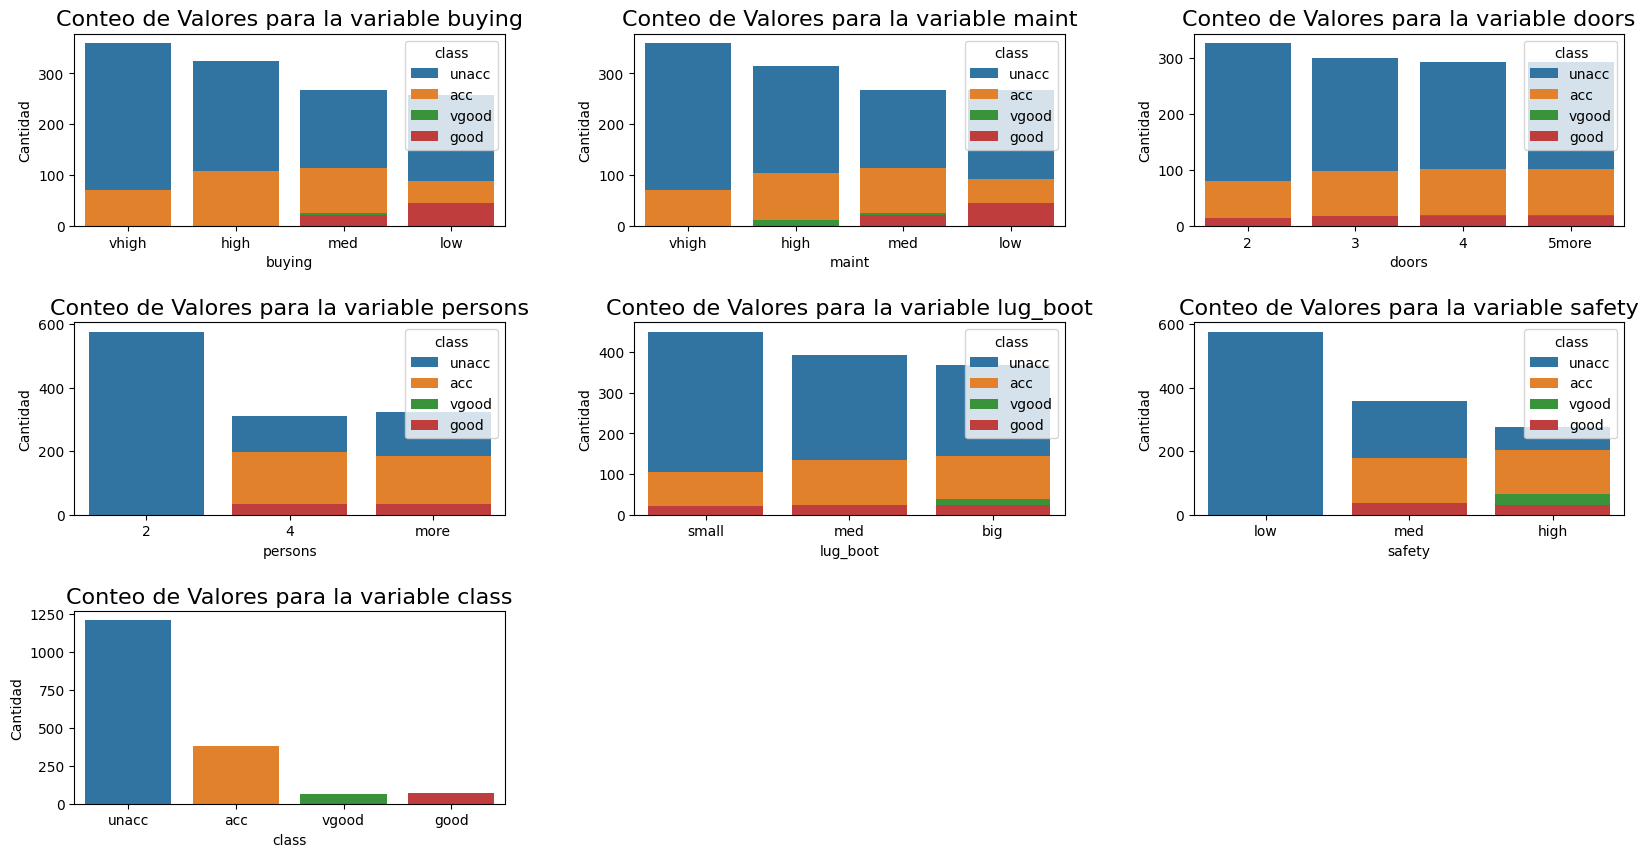

In [138]:
plt.figure(figsize=[20, 10])  # tamaño de la figura de subplot
 
columnas = df.columns
 
# Iterar sobre cada columna y crear un gráfico de barras para ella
for i, columna in enumerate(columnas, 1):
    plt.subplot(3, 3, i)
    ax = sns.countplot(data=df, x=columna, hue='class', dodge=False)
    ax.set_title(f'Conteo de Valores para la variable {columna}', fontsize=16)
    ax.set_xlabel(columna, fontsize=10)
    ax.set_ylabel('Cantidad', fontsize=10)
 
# Ajustar espacios entre subtramas
plt.subplots_adjust(hspace=0.5, wspace=0.3)
 
# Mostrar la gráfica
plt.show()

El dataset contiene 7 variables, 6 variables explicativas y una variable objetivo. Tanto las variables explicativas como la variable objetivo son de tipo categorica.

Al observar los graficos anteriores se puede observar: 
* Al evaluar el costo de mantenimiento (variable maint), se destaca que la mayoría de los carros clasificados como "muy buenos" tienen un mantenimiento de costo alto. Este hallazgo sugiere una posible correlación entre un mayor gasto en mantenimiento y la calidad del vehículo.
* La capacidad de pasajeros muestra una conexión interesante con la valoración del carro. Los carros considerados como "aceptables" o "buenos" tienen una capacidad de transporte de 4 personas o más. Este patrón podría indicar que los compradores de carros con una valoración más alta valoran la capacidad de llevar a más pasajeros.
* Se observa que los carros catalogados como "muy buenos" muestran un nivel de seguridad (variable safety) notablemente alto. Esta relación sugiere que los compradores que priorizan la seguridad están más inclinados hacia carros con una valoración más alta.
* En cuanto a la variable objetivo del dataset, la mayoría de los carros caen en la categoría de "no aceptables". Además, es importante destacar que los carros con valoraciones "buenos" y "muy buenos" son minoritarios en comparación con los no aceptables, lo que podria afectar La precisión de modelos de clasificación dado que las clases están desbalanceadas.

#### 5. La variable class es la variable objetivo, haga una partición adecuada de la base para determinar entrenamiento y testeo.

In [139]:
# Transformacion de los Datos
# Crear el codificador OrdinalEncoder
# Definir el orden personalizado de las categorías para cada característica
custom_categories_carac = [['low', 'med', 'high', 'vhigh'],    # buying
                           ['low', 'med', 'high', 'vhigh'],    # maint
                           ['2', '3', '4', '5more'],           # doors
                           ['2', '4', 'more'],                 # persons
                           ['small', 'med', 'big'],            # lug_boot
                           ['low', 'med', 'high']]             # safety

custom_categories_target = [['unacc','acc','good','vgood']]     # class



# Crear el codificador OrdinalEncoder con el orden personalizado
encoder_carac = OrdinalEncoder(categories=custom_categories_carac)
encoder_target = OrdinalEncoder(categories=custom_categories_target)

# Ajustar y transformar los datos
encoded_dataX = encoder_carac.fit_transform(X[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
encoded_datay = encoder_target.fit_transform(y)

# Convertir los datos codificados a DataFrame
encoded_X = pd.DataFrame(encoded_dataX, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
encoded_y = pd.DataFrame(encoded_datay, columns=['class'])

# Mostrar el DataFrame codificado
print(encoded_X)
print(encoded_y)

      buying  maint  doors  persons  lug_boot  safety
0        3.0    3.0    0.0      0.0       0.0     0.0
1        3.0    3.0    0.0      0.0       0.0     1.0
2        3.0    3.0    0.0      0.0       0.0     2.0
3        3.0    3.0    0.0      0.0       1.0     0.0
4        3.0    3.0    0.0      0.0       1.0     1.0
...      ...    ...    ...      ...       ...     ...
1723     0.0    0.0    3.0      2.0       1.0     1.0
1724     0.0    0.0    3.0      2.0       1.0     2.0
1725     0.0    0.0    3.0      2.0       2.0     0.0
1726     0.0    0.0    3.0      2.0       2.0     1.0
1727     0.0    0.0    3.0      2.0       2.0     2.0

[1728 rows x 6 columns]
      class
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
1723    2.0
1724    3.0
1725    0.0
1726    2.0
1727    3.0

[1728 rows x 1 columns]


In [140]:
Xtrain, Xtest, ytrain, ytest  = train_test_split(encoded_X
                                                 , encoded_y, test_size=0.2, random_state=123)

In [141]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1382, 6)
(1382, 1)
(346, 6)
(346, 1)


#### 6. Aplique varios modelos de aprendizaje y determine los reportes de clasificación del paquete scikit-learn.

##### Regresion Logistica

In [142]:
#Modelo de Regresion Logistica
modelo_lr = LogisticRegression(random_state=123)

modelo_lr.fit(Xtrain, ytrain)
predicted_lr=modelo_lr.predict(Xtrain)

print("Modelo Regresion Lineal: %3f" % modelo_lr.score(Xtest, ytest))


Modelo Regresion Lineal: 0.812139


C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KNN

In [143]:
#Modelo KNN
modelo_knn = KNeighborsClassifier(n_neighbors=3)

modelo_knn.fit(Xtrain, ytrain)
predicted_knn=modelo_knn.predict(Xtrain)

print("Modelo KNN: %3f" % modelo_knn.score(Xtest, ytest))


Modelo KNN: 0.861272


C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Random Forest

In [144]:
modelo_rf = RandomForestClassifier(max_depth=4, random_state=123)

modelo_rf.fit(Xtrain, ytrain)
predicted = modelo_rf.predict(Xtrain)

print("Modelo Random Forest: %3f" % modelo_rf.score(Xtest, ytest))

C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo Random Forest: 0.869942


Arbol de Desicion

In [145]:
modelo_dt = DecisionTreeClassifier(max_depth=4, random_state=123)

modelo_dt.fit(Xtrain, ytrain)
predicted = modelo_dt.predict(Xtrain)

print("Modelo Arbol de Desicion: %3f" % modelo_dt.score(Xtest, ytest))

Modelo Arbol de Desicion: 0.835260


#### 7. Resuma los estadísticos de validación según la implementación en la base de testeo.

Regresion Logisticas

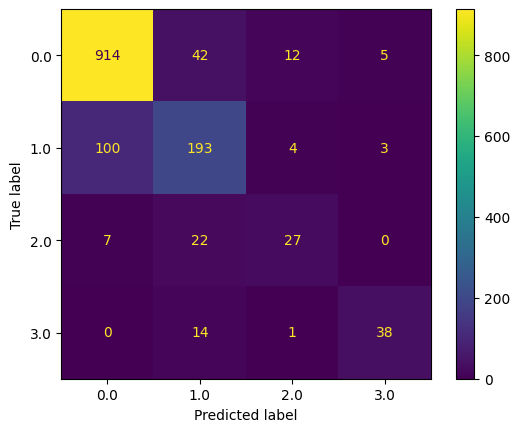

In [146]:
metrics.ConfusionMatrixDisplay.from_estimator(modelo_lr, Xtrain, ytrain)
plt.show()

In [147]:
def evaluation_parametrics(y_train,yp_train,y_test,yp_test):
  print("--------------------------------------------------------------------------")
  print("Classification Report for Train Data")
  print(metrics.classification_report(y_train, yp_train))
  print("Classification Report for Test Data")
  print(metrics.classification_report(y_test, yp_test))
  print("--------------------------------------------------------------------------")
  # Accuracy
  print("Accuracy on Train Data is: {}".format(round(metrics.accuracy_score(y_train,yp_train),2)))
  print("Accuracy on Test Data is: {}".format(round(metrics.accuracy_score(y_test,yp_test),2)))
  print("--------------------------------------------------------------------------")
  # Precision
  print("Precision on Train Data is: {}".format(round(metrics.precision_score(y_train,yp_train,average = "weighted"),2)))
  print("Precision on Test Data is: {}".format(round(metrics.precision_score(y_test,yp_test,average = "weighted"),2)))
  print("--------------------------------------------------------------------------")
  # Recall 
  print("Recall on Train Data is: {}".format(round(metrics.recall_score(y_train,yp_train,average = "weighted"),2)))
  print("Recall on Test Data is: {}".format(round(metrics.recall_score(y_test,yp_test,average = "weighted"),2)))
  print("--------------------------------------------------------------------------")
  # F1 Score
  print("F1 Score on Train Data is: {}".format(round(metrics.f1_score(y_train,yp_train,average = "weighted"),2)))
  print("F1 Score on Test Data is: {}".format(round(metrics.f1_score(y_test,yp_test,average = "weighted"),2)))
  print("--------------------------------------------------------------------------")

In [148]:
def ROC(X, y, model):

  # split into train/test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

  # fit model
  clf = OneVsRestClassifier(model)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  pred_prob = clf.predict_proba(X_test)
  pred_prob = np.nan_to_num(pred_prob)

  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}

  n_class = 4

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)

  # plotting
  fig, ax = plt.subplots(figsize=(10,8))
  ax.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='unacc')
  ax.plot(fpr[1], tpr[1], linestyle='--',color='green', label='acc')
  ax.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='good')
  ax.plot(fpr[3], tpr[3], linestyle='--',color='black', label='vgood')
  ax.plot([0, 1], [0, 1], linestyle='--',color='red', label='No Skill')
  ax.set_title(f'Multiclass ROC curve -  {model.__class__.__name__}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive rate')
  ax.grid(True)

  return ax.legend(loc='best')

In [149]:
#Regresion Logistica
ytrain_pred_lr=modelo_lr.predict(Xtrain)
ytest_pred_lr=modelo_lr.predict(Xtest)

evaluation_parametrics(ytrain,ytrain_pred_lr,ytest,ytest_pred_lr)

--------------------------------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       973
         1.0       0.71      0.64      0.68       300
         2.0       0.61      0.48      0.54        56
         3.0       0.83      0.72      0.77        53

    accuracy                           0.85      1382
   macro avg       0.76      0.70      0.73      1382
weighted avg       0.84      0.85      0.84      1382

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       237
         1.0       0.68      0.57      0.62        84
         2.0       0.57      0.31      0.40        13
         3.0       0.77      0.83      0.80        12

    accuracy                           0.81       346
   macro avg       0.72      0.66      0.68       346
weighted avg       0.80      0.81    

KNN

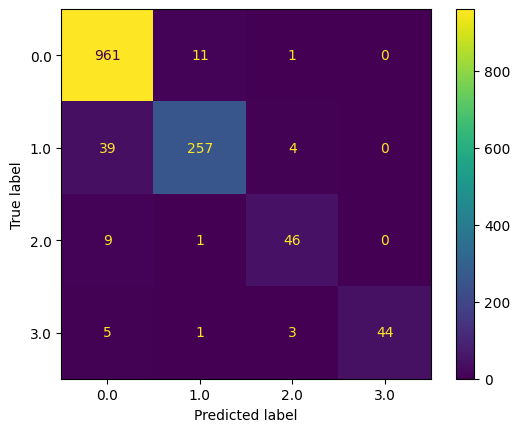

In [150]:
metrics.ConfusionMatrixDisplay.from_estimator(modelo_knn, Xtrain, ytrain)
plt.show()

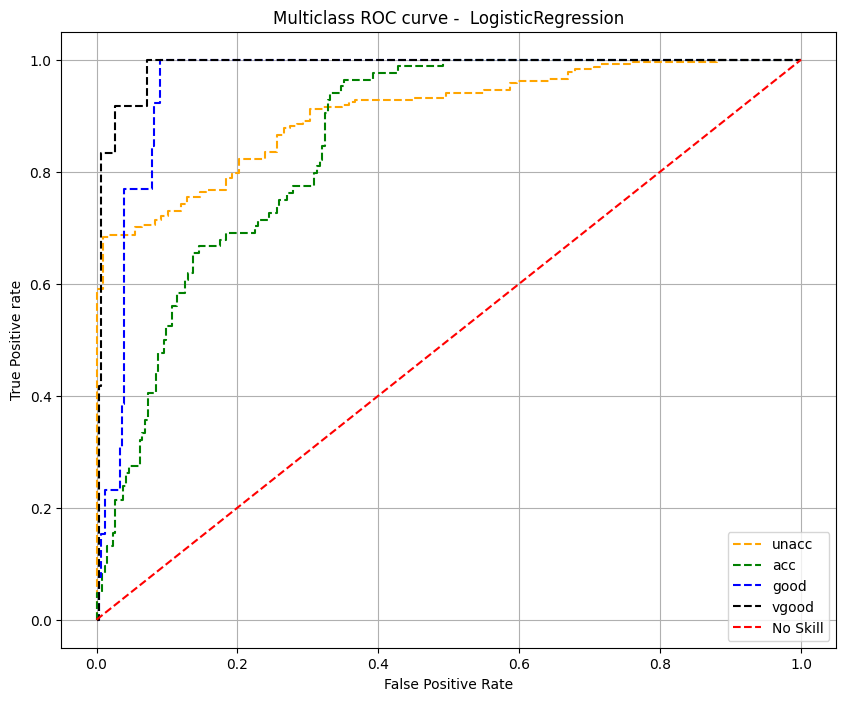

In [151]:
ROC(encoded_X,encoded_y,modelo_lr)

In [152]:
ytrain_pred_knn=modelo_knn.predict(Xtrain)
ytest_pred_knn=modelo_knn.predict(Xtest)

evaluation_parametrics(ytrain,ytrain_pred_knn,ytest,ytest_pred_knn)

--------------------------------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       973
         1.0       0.95      0.86      0.90       300
         2.0       0.85      0.82      0.84        56
         3.0       1.00      0.83      0.91        53

    accuracy                           0.95      1382
   macro avg       0.94      0.87      0.90      1382
weighted avg       0.95      0.95      0.95      1382

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       237
         1.0       0.85      0.67      0.75        84
         2.0       0.44      0.31      0.36        13
         3.0       1.00      0.67      0.80        12

    accuracy                           0.86       346
   macro avg       0.79      0.65      0.71       346
weighted avg       0.86      0.86    

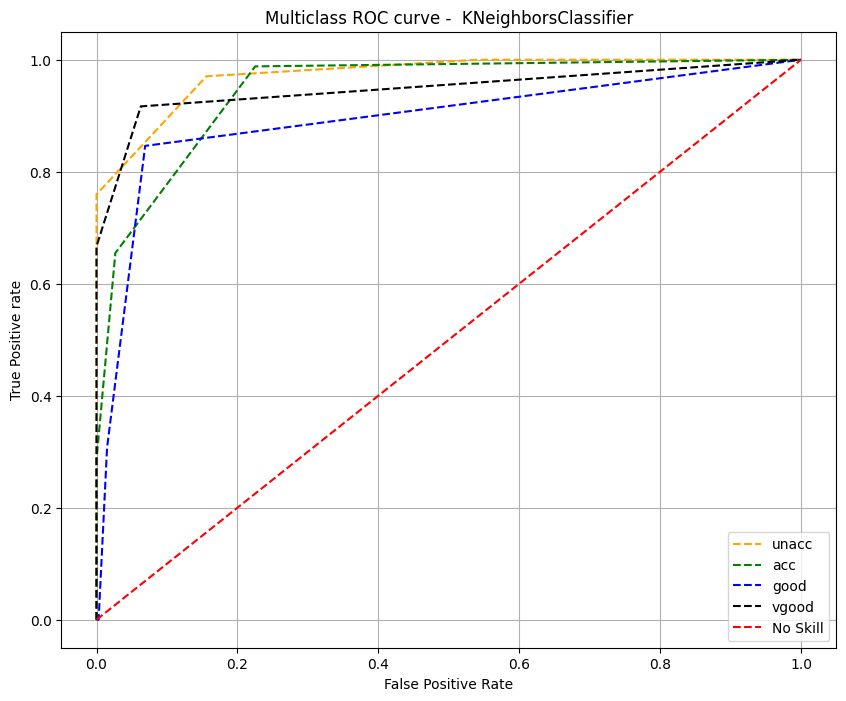

In [153]:
ROC(encoded_X,encoded_y,modelo_knn)

Random Forest

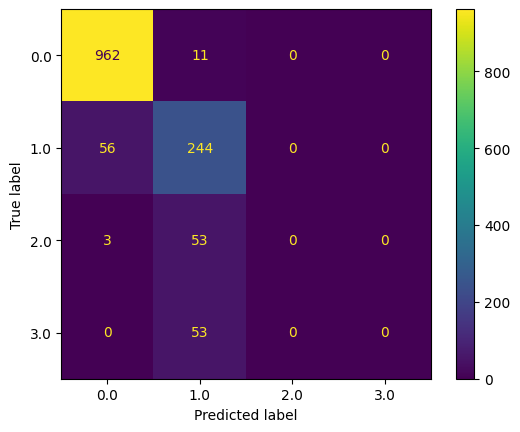

In [154]:
metrics.ConfusionMatrixDisplay.from_estimator(modelo_rf, Xtrain, ytrain)
plt.show()

In [155]:
ytrain_pred_rf=modelo_rf.predict(Xtrain)
ytest_pred_rf=modelo_rf.predict(Xtest)

evaluation_parametrics(ytrain,ytrain_pred_rf,ytest,ytest_pred_rf)

--------------------------------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       973
         1.0       0.68      0.81      0.74       300
         2.0       0.00      0.00      0.00        56
         3.0       0.00      0.00      0.00        53

    accuracy                           0.87      1382
   macro avg       0.40      0.45      0.43      1382
weighted avg       0.81      0.87      0.84      1382

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       237
         1.0       0.70      0.82      0.75        84
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00        12

    accuracy                           0.87       346
   macro avg       0.41      0.45      0.43       346
weighted avg       0.81      0.87    

C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

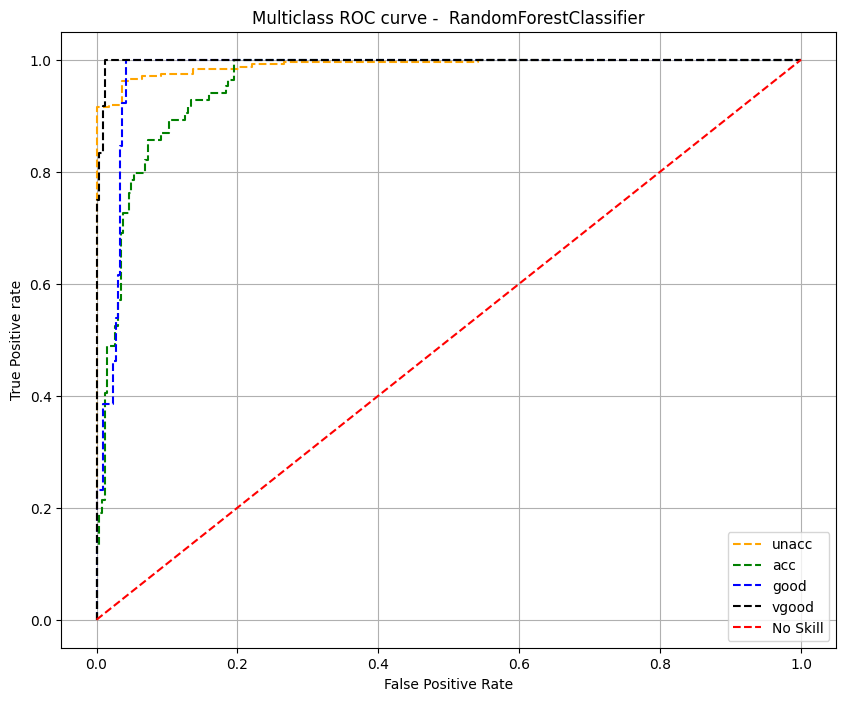

In [156]:
ROC(encoded_X,encoded_y,modelo_rf)

Arbol de Desicion

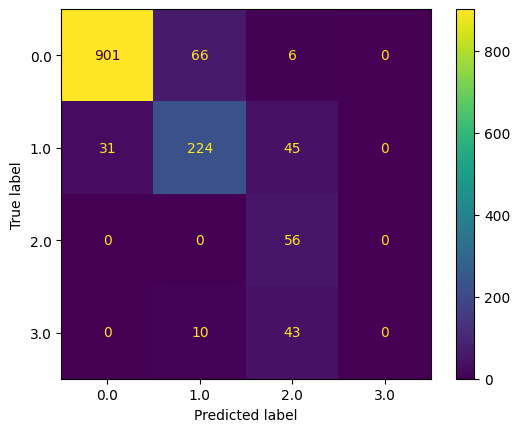

In [157]:
metrics.ConfusionMatrixDisplay.from_estimator(modelo_dt, Xtrain, ytrain)
plt.show()

In [158]:
#Arbol de Desicion
ytrain_pred_dt=modelo_dt.predict(Xtrain)
ytest_pred_dt=modelo_dt.predict(Xtest)

evaluation_parametrics(ytrain,ytrain_pred_dt,ytest,ytest_pred_dt)

--------------------------------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       973
         1.0       0.75      0.75      0.75       300
         2.0       0.37      1.00      0.54        56
         3.0       0.00      0.00      0.00        53

    accuracy                           0.85      1382
   macro avg       0.52      0.67      0.56      1382
weighted avg       0.86      0.85      0.85      1382

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       237
         1.0       0.73      0.73      0.73        84
         2.0       0.31      1.00      0.47        13
         3.0       0.00      0.00      0.00        12

    accuracy                           0.84       346
   macro avg       0.50      0.66      0.53       346
weighted avg       0.86      0.84    

C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

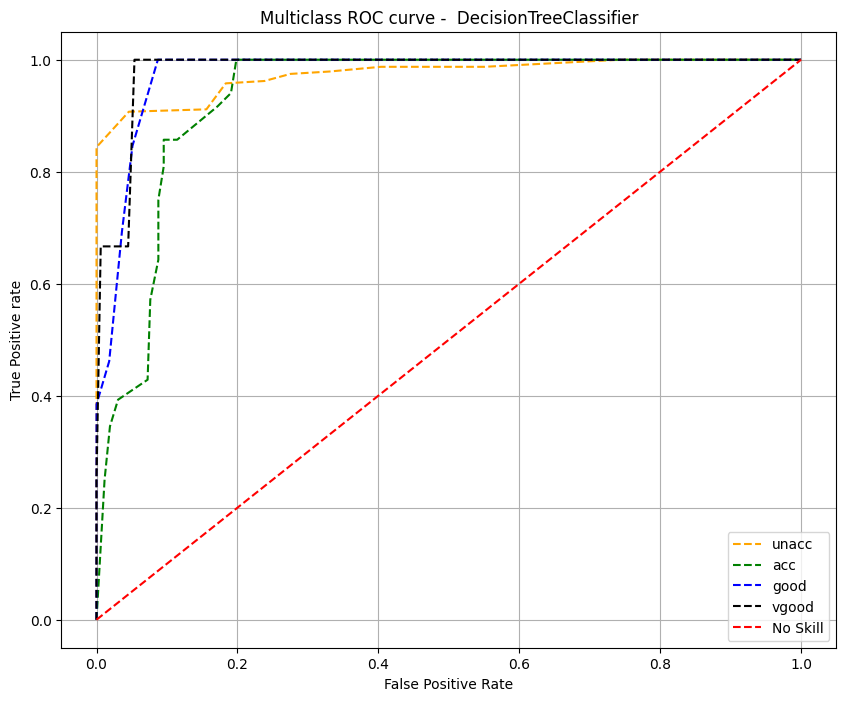

In [159]:
ROC(encoded_X,encoded_y,modelo_dt)

#### 8. Saque sus conclusiones, si ve la posibilidad de reentrenar el modelo y mejorar sus resultados hágalo. En un párrafo explique ¿Cuál de los modelos fue mejor? Justifique adecuadamente su respuesta.

In [160]:
def evaluation_parametrics_df(y_train,yp_train,y_test,yp_test,model_name):
  results_df = pd.DataFrame(columns=['Modelo', 'Accuracy Train', 'Accuracy Test', 'Precision Train', 'Precision Test', 'Recall Train', 'Recall Test', 'F1 Train', 'F1 Test'])
 
  # Accuracy
  accuracy_train=format(round(metrics.accuracy_score(y_train,yp_train),2))
  accuracy_test=format(round(metrics.accuracy_score(y_test,yp_test),2))
  # Precision
  precision_train=format(round(metrics.precision_score(y_train,yp_train,average = "weighted"),2))
  precision_test=format(round(metrics.precision_score(y_test,yp_test,average = "weighted"),2))
  # Recall
  recall_train=format(round(metrics.recall_score(y_train,yp_train,average = "weighted"),2))
  recall_test=format(round(metrics.recall_score(y_test,yp_test,average = "weighted"),2))
  # F1 Score
  f1_train=format(round(metrics.f1_score(y_train,yp_train,average = "weighted"),2))
  f1_test=format(round(metrics.f1_score(y_test,yp_test,average = "weighted"),2))
 
  results_df.loc[len(results_df)] = [model_name, accuracy_train, accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test]
 
  return results_df

In [161]:
df_metrics_lr=evaluation_parametrics_df(ytrain,ytrain_pred_lr,ytest,ytest_pred_lr,'Regresion Logistica')
df_metrics_knn=evaluation_parametrics_df(ytrain,ytrain_pred_knn,ytest,ytest_pred_knn,'Knn')
df_metrics_rf=evaluation_parametrics_df(ytrain,ytrain_pred_rf,ytest,ytest_pred_rf,'Random Forest')
df_metrics_dt=evaluation_parametrics_df(ytrain,ytrain_pred_dt,ytest,ytest_pred_dt,'Arbol de Decision')
 
df_metrics_all=pd.concat([df_metrics_lr,df_metrics_knn,df_metrics_rf,df_metrics_dt],ignore_index=True)
df_metrics_all

C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VivoBook\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

,Modelo,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,Regresion Logistica,0.85,0.81,0.84,0.8,0.85,0.81,0.84,0.8
1,Knn,0.95,0.86,0.95,0.86,0.95,0.86,0.95,0.85
2,Random Forest,0.87,0.87,0.81,0.81,0.87,0.87,0.84,0.84
3,Arbol de Decision,0.85,0.84,0.86,0.86,0.85,0.84,0.85,0.84


Basándonos únicamente en el accuracy en el conjunto de prueba, el Random Forest tiene el valor mas alto seguido del KNN, por lo que ambos podrían considerarse los "mejores" modelos en términos de accuracy. Sin embargo, si consideramos otras métricas como la precisión, recall y F1-score, podríamos tener una evaluación diferente.

Si se valora la precisión en particular, KNN (0.86) y Árbol de Decisión (0.86) tienen los valores más altos en el conjunto de pruebas, en cuanto a la metrica recall el Random Forest tiene el más alto (0.87) seguido del KNN (0.86).

El modelo KNN tiene el F1-score más alto en el conjunto de prueba, con un valor de 0.85. 

En resumen, la elección del "mejor" modelo depende de las prioridades específicas del problema y qué métricas son más importantes, en este caso y dado que el dataset presenta un desequilibrio entre las clases de la variable objetivo, seleccionaríamos el modelo KNN como el mejor modelo para este conjunto de datos ya que en general tiene mejores métricas de evaluación.
